# Data generation

If a quantile regression is performed then one can ignore this step.

In [51]:
from scipy.stats import t
from numpy import sqrt
def to_quantile(mean, std, n, q):
    '''
    Compute the q-th quantiles using Student's t-distribution with n-1 degrees of freedom
    '''
    return t.ppf(q, n-1)*std/sqrt(n)+mean
    

In [52]:
to_quantile(1.5, 1, 3, 0.1)

0.41133789209635174

In [59]:
from numpy import arange
def to_submission_quantiles(mean, std, n):
    return np.array([to_quantile(mean, std, n, qi) for qi in arange(0.1,1,0.1)])

In [57]:
to_submission_quantiles(1.5, 1, 3)

array([0.41133789, 0.88762756, 1.14365168, 1.33333333, 1.5       ,
       1.66666667, 1.85634832, 2.11237244, 2.58866211])

This illustrates the effect of degree of freedom.

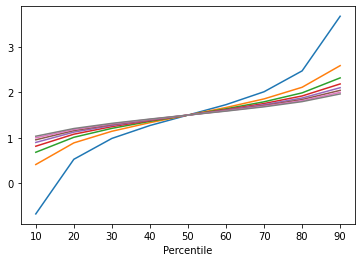

In [80]:
import matplotlib.pyplot as plt
plt.plot(np.array([to_submission_quantiles(1.5,1,df) for df in range(2,10)]).T)
plt.xticks(ticks=range(9), labels=[10,20,30,40,50,60,70,80,90])
plt.xlabel("Percentile")
plt.show()

We also want our function to be able to take in Series:

In [85]:
def columns_to_submission_quantiles(df, q, n):
    t_val = t.ppf(q, n-1)
    return df['mean']+t_val/sqrt(n)*df['std']

# Output to csv

Here we assume that each prediction comes in the form of a pair (mean, std), and that the total degree of freedom of model is n. Furthermore, one has columns ["date", "FIPS"].

In [112]:
import pandas as pd
def to_submission_df(df, n):
    df_new = pd.DataFrame(columns=["id"]+[str(q) for q in range(10, 100, 10)])
    try:
        df_new['id'] = df['date'] + '-' + df['FIPS']
    except:
        print("Wrong input dataframe format.")
    for q in range(10, 100, 10):
        df_new[str(q)] = columns_to_submission_quantiles(df, q/100, n)
    return df_new.set_index("id")

Let's test.

In [115]:
df_test = pd.DataFrame(columns=["date", "FIPS", "mean", "std"])
df_test["date"] = pd.Series(["2020-04-01", "2020-04-01", "2020-04-01"])
df_test["FIPS"] = pd.Series(["10001", "10003", "10005"])
df_test["mean"] = pd.Series([15,1000,31])
df_test["std"] = pd.Series([1, 20, 5])
df_test

,date,FIPS,mean,std
0,2020-04-01,10001,15,1
1,2020-04-01,10003,1000,20
2,2020-04-01,10005,31,5


In [116]:
to_submission_df(df_test, n=3)

,10,20,30,40,50,60,70,80,90
id,,,,,,,,,
2020-04-01-10001,13.911338,14.387628,14.643652,14.833333,15.0,15.166667,15.356348,15.612372,16.088662
2020-04-01-10003,978.226758,987.752551,992.873034,996.666667,1000.0,1003.333333,1007.126966,1012.247449,1021.773242
2020-04-01-10005,25.556689,27.938138,29.218258,30.166667,31.0,31.833333,32.781742,34.061862,36.443311


In [114]:
def to_submission_csv(df, filename):
    df.to_csv(filename, float_format='%.2f')